In [1]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install descartes

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely import wkt
import datetime as dt
import requests
from bs4 import BeautifulSoup

# Introduction

The dataset comes from NYC open data. This is a breakdown of every arrest effected in NYC by the NYPD during the current year (until September).

This data is manually extracted every quarter and reviewed by the Office of Management Analysis and Planning.
Each record represents an arrest effected in NYC by the NYPD and includes information about the type of crime, the location and time of enforcement.

This projects aims to explore the nature of arrests cases in NYC and provide some advice on the police enforcement activities.

# Data Source

https://data.cityofnewyork.us/Public-Safety/NYPD-Arrest-Data-Year-to-Date-/uip8-fykc

search keyword of 'crime' in NYC open data

In [27]:
df=pd.read_csv('NYPD_Arrest.csv')
df.head()

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,New Georeferenced Column
0,218375425,09/26/2020,157.0,RAPE 1,104.0,RAPE,PL 1303501,F,M,1,0,25-44,M,WHITE,982285,201682,40.720255,-74.007090,POINT (-74.00709027999993 40.72025522300004)
1,216884434,08/21/2020,175.0,"SEXUAL ABUSE 3,2",233.0,SEX CRIMES,PL 1305500,M,B,43,0,18-24,M,BLACK,1020316,239179,40.823101,-73.869690,POINT (-73.86969046099993 40.82310129900002)
2,216348943,08/09/2020,109.0,"ASSAULT 2,1,UNCLASSIFIED",106.0,FELONY ASSAULT,PL 1200501,F,B,44,0,25-44,F,BLACK,1007481,241648,40.829921,-73.916056,POINT (-73.91605634499997 40.82992107800004)
3,216186332,08/05/2020,157.0,RAPE 1,104.0,RAPE,PL 1303502,F,B,40,0,25-44,M,WHITE HISPANIC,1004926,234532,40.810396,-73.925311,POINT (-73.92531074499993 40.81039601900005)
4,217452757,09/05/2020,397.0,"ROBBERY,OPEN AREA UNCLASSIFIED",105.0,ROBBERY,PL 160102A,F,B,48,0,25-44,M,BLACK,1015113,245325,40.839990,-73.888461,POINT (-73.88846125799995 40.83999000400007)


In [28]:
row = df.iloc[1,:]
print(row['ARREST_KEY'])

216884434


In [32]:
int(round(39/42*100,0))

93

In [ ]:
df['ARREST_KEY']=df['ARREST_KEY'].apply(lambda x:)

In [7]:
for i in range(5):
    row = df.iloc[i,:]
    
    print(row['PD_CD'], row['KY_CD'])

157.0 104.0
175.0 233.0
109.0 106.0
157.0 104.0
397.0 105.0


# Column Description

ARREST_KEY: Randomly generated persistent ID for each arrest. 

ARREST_DATE: Exact date of arrest for the reported event.

PD_CD: Three digit internal classification code (more granular than Key Code).

PD_DESC: Description of internal classification corresponding with PD code (more granular than Offense Description).

KY_CD: Three digit internal classification code (more general category than PD code).

OFNS_DESC: Description of internal classification corresponding with KY code (more general category than PD description).

LAW_CODE: Law code charges corresponding to the NYS Penal Law, VTL and other various local laws.

LAW_CAT_CD: Level of offense: felony, misdemeanor, violation .

ARREST_BORO: Borough of arrest. B(Bronx), S(Staten Island), K(Brooklyn), M(Manhattan), Q(Queens).

ARREST_PRECINCT: Precinct where the arrest occurred.

JURISDICTION_CODE: Jurisdiction responsible for arrest. Jurisdiction codes 0(Patrol), 1(Transit) and 2(Housing). represent NYPD whilst codes 3 and more represent non NYPD jurisdictions.

AGE_GROUP: Perpetrator’s age within a category.

PERP_SEX: Perpetrator’s sex description.

PERP_RACE: Perpetrator’s race description.

X_COORD_CD: Midblock X-coordinate for New York State Plane Coordinate System, Long Island Zone, NAD 83, units feet (FIPS 3104).

Y_COORD_CD: Midblock Y-coordinate for New York State Plane Coordinate System, Long Island Zone, NAD 83, units feet (FIPS 3104).

Latitude: Latitude coordinate for Global Coordinate System, WGS 1984, decimal degrees (EPSG 4326).

Longitude: Longitude coordinate for Global Coordinate System, WGS 1984, decimal degrees (EPSG 4326).

# Data Preprocessing

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103376 entries, 0 to 103375
Data columns (total 19 columns):
ARREST_KEY                  103376 non-null int64
ARREST_DATE                 103376 non-null object
PD_CD                       103362 non-null float64
PD_DESC                     103352 non-null object
KY_CD                       103352 non-null float64
OFNS_DESC                   103352 non-null object
LAW_CODE                    103376 non-null object
LAW_CAT_CD                  102406 non-null object
ARREST_BORO                 103376 non-null object
ARREST_PRECINCT             103376 non-null int64
JURISDICTION_CODE           103376 non-null int64
AGE_GROUP                   103376 non-null object
PERP_SEX                    103376 non-null object
PERP_RACE                   103376 non-null object
X_COORD_CD                  103376 non-null int64
Y_COORD_CD                  103376 non-null int64
Latitude                    103376 non-null float64
Longitude               

There is no missing value and data quality is fine.

In [7]:
#convert Borough of arrest. B(Bronx), S(Staten Island), K(Brooklyn), M(Manhattan), Q(Queens)
df.loc[df['ARREST_BORO']=='M','ARREST_BORO']='Manhattan'
df.loc[df['ARREST_BORO']=='B','ARREST_BORO']='Bronx'
df.loc[df['ARREST_BORO']=='K','ARREST_BORO']='Brooklyn'
df.loc[df['ARREST_BORO']=='S','ARREST_BORO']='Staten Island'
df.loc[df['ARREST_BORO']=='Q','ARREST_BORO']='Queens'

In [8]:
df.head()

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,New Georeferenced Column
0,218375425,09/26/2020,157.0,RAPE 1,104.0,RAPE,PL 1303501,F,Manhattan,1,0,25-44,M,WHITE,982285,201682,40.720255,-74.007090,POINT (-74.00709027999993 40.72025522300004)
1,216884434,08/21/2020,175.0,"SEXUAL ABUSE 3,2",233.0,SEX CRIMES,PL 1305500,M,Bronx,43,0,18-24,M,BLACK,1020316,239179,40.823101,-73.869690,POINT (-73.86969046099993 40.82310129900002)
2,216348943,08/09/2020,109.0,"ASSAULT 2,1,UNCLASSIFIED",106.0,FELONY ASSAULT,PL 1200501,F,Bronx,44,0,25-44,F,BLACK,1007481,241648,40.829921,-73.916056,POINT (-73.91605634499997 40.82992107800004)
3,216186332,08/05/2020,157.0,RAPE 1,104.0,RAPE,PL 1303502,F,Bronx,40,0,25-44,M,WHITE HISPANIC,1004926,234532,40.810396,-73.925311,POINT (-73.92531074499993 40.81039601900005)
4,217452757,09/05/2020,397.0,"ROBBERY,OPEN AREA UNCLASSIFIED",105.0,ROBBERY,PL 160102A,F,Bronx,48,0,25-44,M,BLACK,1015113,245325,40.839990,-73.888461,POINT (-73.88846125799995 40.83999000400007)


# Data Visualization

# Scatter Plot 

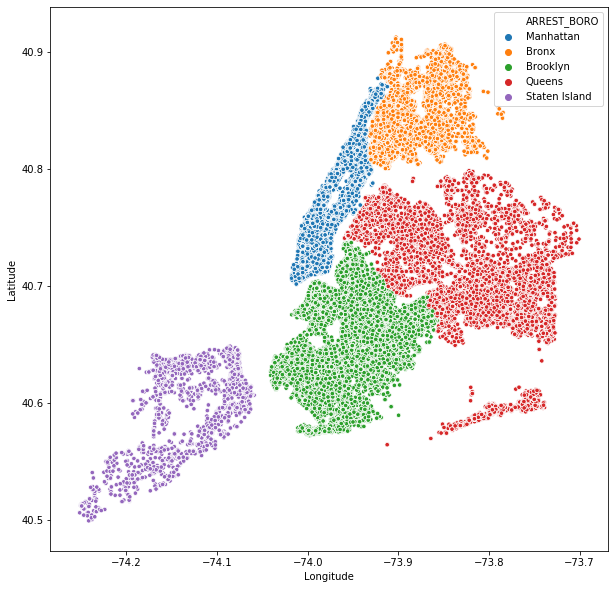

In [9]:
#This is scatter plot for the latitude and longtitude of all arrrests in five districts.
plt.figure(figsize=(10,10))
sns.scatterplot(x='Longitude', y='Latitude', hue='ARREST_BORO',s=20,data=df)

# NYC Borough Map using Geopandas

In [10]:
#get the arrest case count for each borough
boro_count=df.groupby('ARREST_BORO')['ARREST_KEY'].count().reset_index()
boro_count.rename(columns={'ARREST_BORO':'BoroName','ARREST_KEY':'ArrestCount'},inplace=True)
boro_count

,BoroName,ArrestCount
0,Bronx,23963
1,Brooklyn,27962
2,Manhattan,24637
3,Queens,22316
4,Staten Island,4498


In [11]:
#get the nyc borough dataset of shape and geometry from geopandas 
nyc = gpd.read_file(gpd.datasets.get_path('nybb'))
nyc.head(5)

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((970217.022 145643.332, 970227...."
1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((1029606.077 156073.814, 102957..."
2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((1021176.479 151374.797, 102100..."
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((981219.056 188655.316, 980940...."
4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((1012821.806 229228.265, 101278..."


In [12]:
#merge the two dataframe
bc_geo=nyc.merge(boro_count,on='BoroName')
bc_geo

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry,ArrestCount
0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((970217.022 145643.332, 970227....",4498
1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((1029606.077 156073.814, 102957...",22316
2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((1021176.479 151374.797, 102100...",27962
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((981219.056 188655.316, 980940....",24637
4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((1012821.806 229228.265, 101278...",23963


0    Annotation(941639, 150932, 'Staten Island')
1      Annotation(1.03458e+06, 197117, 'Queens')
2         Annotation(998769, 174170, 'Brooklyn')
3        Annotation(993337, 222451, 'Manhattan')
4       Annotation(1.02117e+06, 249938, 'Bronx')
dtype: object

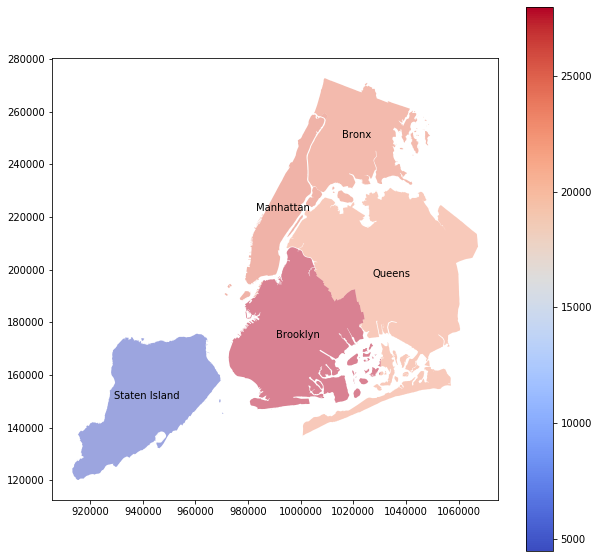

In [13]:
#plot the shape of nyc borough and the arrest count
fig,ax = plt.subplots(1,1, figsize=(10,10))
bc_geo.plot(column='ArrestCount', cmap='coolwarm', alpha=.5, ax=ax, legend=True)
bc_geo.apply(lambda x: ax.annotate(s=x.BoroName, color='black',xy=x.geometry.centroid.coords[0],ha='center'), axis=1)

We use the geopandas to plot the NYC map and from this plot, we can find the the total number of arrest cases in each area. The more closer the color is to red, there will be more cases.The Brooklyn has the most arrest cases.

# NYC Percinct Map

In the last two graph, we obsereve the arrest in terms of the district level, now we want to alter the dimensional to percinct level and plot the NYC precinct map and show the number of arrest cases in each precinct. But there is no such dataset in the geopandas package, so I web scraped the data with shape area, shape length and all the latitude and longitude information of each percinct from the NYC open data API using the requests package. 

In [14]:
#get the json file from API
r=requests.get('https://data.cityofnewyork.us/api/views/kmub-vria/rows.json?accessType=DOWNLOAD')
r=r.json()

In [15]:
#Parse the json file and get the shape area,length,precinct and geometry ans store in the dictionary
dic={}
dic['Shape_Area']=[]
dic['Shape_Leng']=[]
dic['ARREST_PRECINCT']=[]
dic['geometry']=[]
for i in r['data']:
    dic['Shape_Area'].append(i[8])
    dic['Shape_Leng'].append(i[-2])
    dic['geometry'].append(i[9])
    dic['ARREST_PRECINCT'].append(i[-1])

In [16]:
#transform the string to the datatype required by the geopandas
nyc_precinct=pd.DataFrame(dic,columns=['Shape_Area','Shape_Leng','geometry','ARREST_PRECINCT'])
nyc_precinct['ARREST_PRECINCT']=nyc_precinct['ARREST_PRECINCT'].astype('int64')
nyc_precinct['Shape_Area']=nyc_precinct['Shape_Area'].astype('float64')
nyc_precinct['Shape_Leng']=nyc_precinct['Shape_Leng'].astype('float64')
nyc_precinct['geometry']=nyc_precinct['geometry'].apply(wkt.loads)

In [17]:
nyc_precinct

,Shape_Area,Shape_Leng,geometry,ARREST_PRECINCT
0,80969.426497,4.731588e+07,(POLYGON ((-74.0438776157395 40.69018767637665...,1
1,18676.124259,1.808880e+07,(POLYGON ((-73.98863862848766 40.7229337202636...,5
2,26402.900691,2.209819e+07,(POLYGON ((-73.99968392160721 40.7385522486597...,6
3,29978.094261,4.533179e+07,(POLYGON ((-73.92854313809303 40.6645732858473...,71
4,87968.194520,1.046213e+08,(POLYGON ((-73.99840899113158 40.6718687230323...,72
...,...,...,...,...
72,60051.601409,1.133427e+08,(POLYGON ((-73.85907893495987 40.7625228322724...,115
73,92981.054878,2.323947e+08,(POLYGON ((-74.05356753570321 40.6036964668284...,120
74,136834.152823,4.756924e+08,(POLYGON ((-74.15945602438185 40.6414483333240...,121
75,154876.386299,4.548001e+08,(POLYGON ((-74.05050806403284 40.5664220346634...,122


In [18]:
#get the precinct_count dataframe
precinct_count=df.groupby('ARREST_PRECINCT')['ARREST_KEY'].count().reset_index()
precinct_count.rename(columns={'ARREST_PRECINCT':'ARREST_PRECINCT','ARREST_KEY':'ArrestCount'},inplace=True)
precinct_count

,ARREST_PRECINCT,ArrestCount
0,1,1117
1,5,1635
2,6,1378
3,7,980
4,9,971
...,...,...
72,115,1930
73,120,1749
74,121,1304
75,122,914


In [19]:
#merge the precinct_count and nyc_precinct and transform to the geodataframe
pc_geo=precinct_count.merge(nyc_precinct,on='ARREST_PRECINCT')
pc_geo=gpd.GeoDataFrame(pc_geo, geometry='geometry')
pc_geo

,ARREST_PRECINCT,ArrestCount,Shape_Area,Shape_Leng,geometry
0,1,1117,80969.426497,4.731588e+07,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ..."
1,5,1635,18676.124259,1.808880e+07,"MULTIPOLYGON (((-73.98864 40.72293, -73.98869 ..."
2,6,1378,26402.900691,2.209819e+07,"MULTIPOLYGON (((-73.99968 40.73855, -73.99684 ..."
3,7,980,17301.308681,1.836402e+07,"MULTIPOLYGON (((-73.97345 40.71896, -73.97351 ..."
4,9,971,19773.233396,2.139423e+07,"MULTIPOLYGON (((-73.97161 40.72672, -73.97163 ..."
...,...,...,...,...,...
72,115,1930,60051.601409,1.133427e+08,"MULTIPOLYGON (((-73.85908 40.76252, -73.85943 ..."
73,120,1749,92981.054878,2.323947e+08,"MULTIPOLYGON (((-74.05357 40.60370, -74.05407 ..."
74,121,1304,136834.152823,4.756924e+08,"MULTIPOLYGON (((-74.15946 40.64145, -74.15975 ..."
75,122,914,154876.386299,4.548001e+08,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."


0       Annotation(-74.0121, 40.7098, '1')
1       Annotation(-73.9971, 40.7164, '5')
2       Annotation(-74.0024, 40.7337, '6')
3       Annotation(-73.9839, 40.7154, '7')
4       Annotation(-73.9834, 40.7263, '9')
                      ...                 
72    Annotation(-73.8762, 40.7626, '115')
73    Annotation(-74.0964, 40.6253, '120')
74    Annotation(-74.1662, 40.6068, '121')
75    Annotation(-74.1159, 40.5755, '122')
76    Annotation(-74.2059, 40.5368, '123')
Length: 77, dtype: object

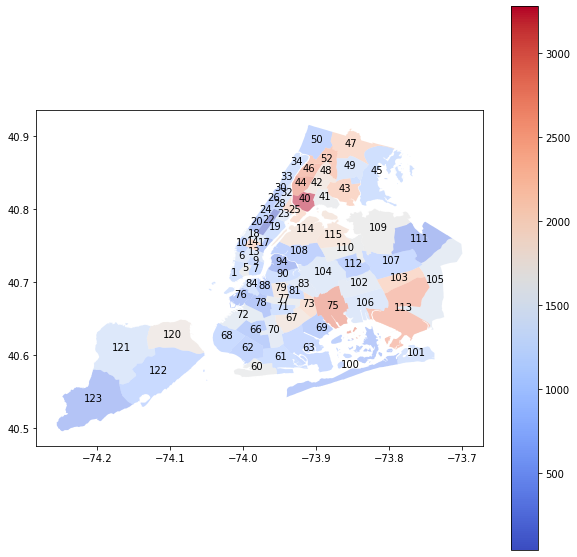

In [20]:
#plot the geodataframe
fig,ax = plt.subplots(1,1, figsize=(10,10))
pc_geo.plot(column='ArrestCount', cmap='coolwarm', alpha=.5, ax=ax, legend=True)
pc_geo.apply(lambda x: ax.annotate(s=x.ARREST_PRECINCT, color='black',xy=x.geometry.centroid.coords[0],ha='center'), axis=1)

From this graph, we can see that the 40th precinct in Bronx has the most arrest cases. Most precincts in Manhattan is quite safe, except the 14th precinct, which has over 1500 caese in total. 

# Time Series Plot

We want to make a time series plot to show the number of daily arrest cases in five districts and the date need to be consecutive, while there are no records for Staten Island in certain days because there are no cases. So we we need to find such days and append the row with number of 0.

In [21]:
#get the daily arrest case count for each borough
month_count=df.groupby(['ARREST_DATE','ARREST_BORO'])['ARREST_KEY'].count().reset_index()
month_count.head()

,ARREST_DATE,ARREST_BORO,ARREST_KEY
0,01/01/2020,Bronx,115
1,01/01/2020,Brooklyn,155
2,01/01/2020,Manhattan,96
3,01/01/2020,Queens,107
4,01/01/2020,Staten Island,18


In [22]:
#the two missing days are 4/17/2020 and 7/11/2020
a=list(month_count[month_count['ARREST_BORO']=='Staten Island']['ARREST_DATE'])
b=list(month_count[month_count['ARREST_BORO']=='Queens']['ARREST_DATE'])
set(b)-set(a)

{'04/17/2020', '07/11/2020'}

In [23]:
#append the row for these two dates with number of arrest cases equal 0
new_rows=[pd.Series(['04/17/2020','Staten Island',0],index=month_count.columns),\
          pd.Series(['07/11/2020','Staten Island',0],index=month_count.columns)]
month_count=month_count.append(new_rows,ignore_index=True)

In [24]:
#sort the dataframe by arrest date
month_count.sort_values(by=['ARREST_DATE','ARREST_BORO'], inplace=True)
month_count

,ARREST_DATE,ARREST_BORO,ARREST_KEY
0,01/01/2020,Bronx,115
1,01/01/2020,Brooklyn,155
2,01/01/2020,Manhattan,96
3,01/01/2020,Queens,107
4,01/01/2020,Staten Island,18
...,...,...,...
1363,09/30/2020,Bronx,129
1364,09/30/2020,Brooklyn,116
1365,09/30/2020,Manhattan,92
1366,09/30/2020,Queens,77


In [25]:
#change the arrest_date data type to datetime 
date_format = "%m/%d/%Y"
month_count['DATE']=month_count['ARREST_DATE'].apply(lambda x:dt.datetime.strptime(x, date_format))
month_count['DATE']

0      2020-01-01
1      2020-01-01
2      2020-01-01
3      2020-01-01
4      2020-01-01
          ...    
1363   2020-09-30
1364   2020-09-30
1365   2020-09-30
1366   2020-09-30
1367   2020-09-30
Name: DATE, Length: 1370, dtype: datetime64[ns]

/Users/yaxinwan/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Daily Arrest Number by Boro')

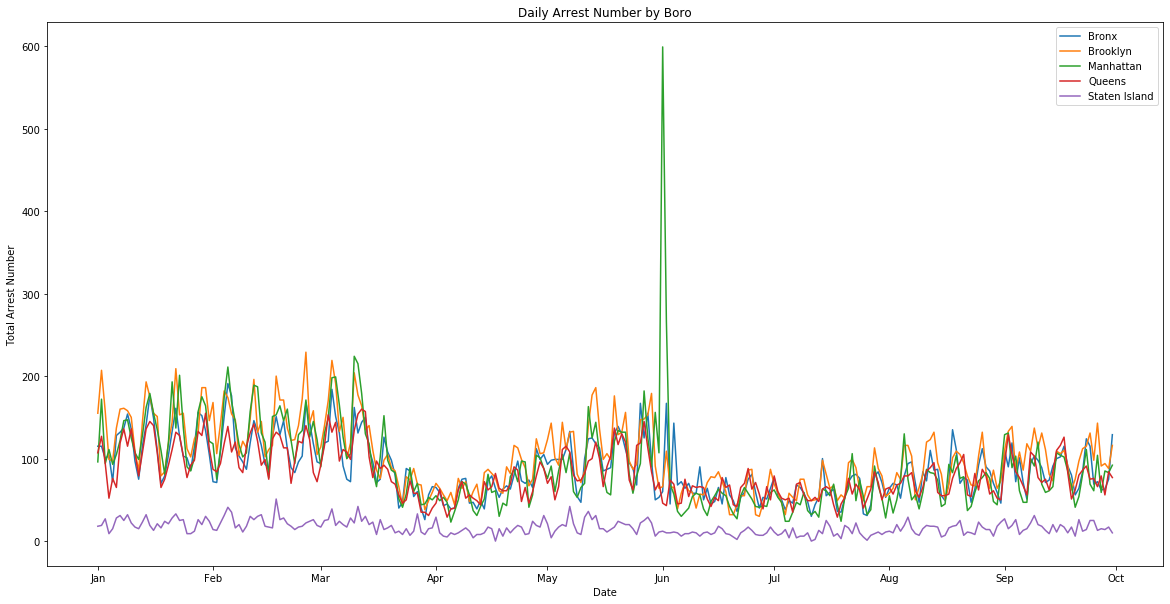

In [26]:
import matplotlib.dates as mdates
boro=['Bronx','Brooklyn','Manhattan','Queens','Staten Island']
fig,axes=plt.subplots(figsize=(20,10))
x=month_count['DATE'].unique()
for i in boro:
    y=month_count[month_count['ARREST_BORO']==i]['ARREST_KEY']
    xfmt = mdates.DateFormatter('%b')
    months = mdates.MonthLocator()
    axes.xaxis.set_major_locator(months)
    axes.xaxis.set_major_formatter(xfmt)
    axes.plot(x,y)
axes.legend(boro,loc='best')
axes.set_ylabel('Total Arrest Number')
axes.set_xlabel('Date')
axes.set_title('Daily Arrest Number by Boro')

We can see that in early of June, the number of arrest in Manhattan increased dramatically, probably due to the protests for'Black lives matter'. There are always the fewest cases in staten Island among all the districts and Staten Island could be the most safe area in New York.

# Question: What is the crime rate of each race in each borough?

In [27]:
#the arrest cases for each race in each district
res=pd.pivot_table(df, values='ARREST_KEY', index=['PERP_RACE'],\
          columns=['ARREST_BORO'], aggfunc='count')
res

ARREST_BORO,Bronx,Brooklyn,Manhattan,Queens,Staten Island
PERP_RACE,,,,,
AMERICAN INDIAN/ALASKAN NATIVE,44,69,40,106,11
ASIAN / PACIFIC ISLANDER,353,1073,677,3221,171
BLACK,11157,16506,12385,8858,1658
BLACK HISPANIC,4029,1321,2429,1047,161
UNKNOWN,140,89,124,126,26
WHITE,903,3709,2992,2566,1537
WHITE HISPANIC,7337,5195,5990,6392,934


In [28]:
#transform the aggregate number to percentage
for i in res.columns:
    res[i]=res[i].apply(lambda x:x/res[i].sum(axis=0))\
    .astype(float).map("{:.2%}".format)
res

ARREST_BORO,Bronx,Brooklyn,Manhattan,Queens,Staten Island
PERP_RACE,,,,,
AMERICAN INDIAN/ALASKAN NATIVE,0.18%,0.25%,0.16%,0.47%,0.24%
ASIAN / PACIFIC ISLANDER,1.47%,3.84%,2.75%,14.43%,3.80%
BLACK,46.56%,59.03%,50.27%,39.69%,36.86%
BLACK HISPANIC,16.81%,4.72%,9.86%,4.69%,3.58%
UNKNOWN,0.58%,0.32%,0.50%,0.56%,0.58%
WHITE,3.77%,13.26%,12.14%,11.50%,34.17%
WHITE HISPANIC,30.62%,18.58%,24.31%,28.64%,20.76%


We can see that white hispanic accounts for 30.62% of arrest cases in the Bronx, which is much higher than other districts. The black accounts for 59.03% of arrest cases in Brooklyn, which is the highest among all the five districts.

# Question: What is the crime rate for each age group in each borough?

In [29]:
#the arrest cases for each age group in each district
res=pd.pivot_table(df, values='ARREST_KEY', index=['AGE_GROUP'],\
          columns=['ARREST_BORO'], aggfunc='count')
res

ARREST_BORO,Bronx,Brooklyn,Manhattan,Queens,Staten Island
AGE_GROUP,,,,,
18-24,5108,5796,4438,4595,870
25-44,13179,15364,13493,12250,2506
45-64,4299,5211,5396,4215,910
65+,257,296,322,309,53
<18,1120,1295,988,947,159


In [30]:
#apply lambda function to transform the aggregate number to percentage
for i in res.columns:
    res[i]=res[i].apply(lambda x:x/res[i].sum(axis=0))\
    .astype(float).map("{:.2%}".format)
res

ARREST_BORO,Bronx,Brooklyn,Manhattan,Queens,Staten Island
AGE_GROUP,,,,,
18-24,21.32%,20.73%,18.01%,20.59%,19.34%
25-44,55.00%,54.95%,54.77%,54.89%,55.71%
45-64,17.94%,18.64%,21.90%,18.89%,20.23%
65+,1.07%,1.06%,1.31%,1.38%,1.18%
<18,4.67%,4.63%,4.01%,4.24%,3.53%


We can see that the youth(<18) accounts for 3.53% of all the cases in Staten Island, which is the lowest in all five districts. 25-44 age has the highest crime rate in each borough.

# Question: What is the crime rate for each race of each age group?

In [31]:
#the number of arrest cases for each race in each age group
res=pd.pivot_table(df, values='ARREST_KEY', index=['PERP_RACE'],\
          columns=['AGE_GROUP'], aggfunc='count')

In [32]:
#transform the aggregate number to percentage
for i in res.columns:
    res[i]=res[i].apply(lambda x:x/res[i].sum(axis=0))\
    .astype(float).map("{:.2%}".format)
res

AGE_GROUP,18-24,25-44,45-64,65+,<18
PERP_RACE,,,,,
AMERICAN INDIAN/ALASKAN NATIVE,0.32%,0.25%,0.23%,0.24%,0.29%
ASIAN / PACIFIC ISLANDER,5.33%,5.21%,5.79%,8.97%,3.46%
BLACK,51.71%,46.89%,49.00%,41.47%,63.14%
BLACK HISPANIC,9.99%,8.94%,6.42%,7.28%,10.14%
UNKNOWN,0.51%,0.50%,0.50%,0.40%,0.18%
WHITE,6.87%,12.18%,14.90%,19.00%,3.06%
WHITE HISPANIC,25.27%,26.03%,23.15%,22.64%,19.74%


We can see that for the group of people aged under 18(youth), the black accounts for 63.14% of the arrest cases, which is quite high. This percentage is also much higher than that in other age groups. The government need to give more attention to the education of black youth.

# Questions about offense types 

In [33]:
#find the offense type with the most arrest cases using dataframe 
ofns=df.groupby(['OFNS_DESC'])['ARREST_KEY'].count().reset_index()
ofns[ofns['ARREST_KEY']==ofns['ARREST_KEY'].max()]

,OFNS_DESC,ARREST_KEY
5,ASSAULT 3 & RELATED OFFENSES,17588


In [34]:
#the top 10 most frequent offense type among male using dataframe
male_ofns=df[df['PERP_SEX']=='M'].groupby('OFNS_DESC')['ARREST_KEY'].count().reset_index()
male_ofns.sort_values(by='ARREST_KEY',ascending=False)[:10]

,OFNS_DESC,ARREST_KEY
5,ASSAULT 3 & RELATED OFFENSES,13344
16,FELONY ASSAULT,7564
11,DANGEROUS DRUGS,7266
49,PETIT LARCENY,6804
33,MISCELLANEOUS PENAL LAW,5941
53,ROBBERY,5282
9,CRIMINAL MISCHIEF & RELATED OF,4682
7,BURGLARY,4241
12,DANGEROUS WEAPONS,4203
22,GRAND LARCENY,3818


In [35]:
#the top 10 most frequent offense type among female using dataframe
female_ofns=df[df['PERP_SEX']=='F'].groupby('OFNS_DESC')['ARREST_KEY'].count().reset_index()
female_ofns.sort_values(by='ARREST_KEY',ascending=False)[:10]

,OFNS_DESC,ARREST_KEY
5,ASSAULT 3 & RELATED OFFENSES,4244
16,FELONY ASSAULT,2438
44,PETIT LARCENY,1736
9,CRIMINAL MISCHIEF & RELATED OF,1077
11,DANGEROUS DRUGS,997
22,GRAND LARCENY,870
30,MISCELLANEOUS PENAL LAW,776
48,ROBBERY,710
35,OFFENSES AGAINST PUBLIC ADMINI,649
34,OFF. AGNST PUB ORD SENSBLTY &,508


# SQL

In [36]:
df=pd.read_csv('NYPD_Arrest.csv')
df.head()

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,New Georeferenced Column
0,218375425,09/26/2020,157.0,RAPE 1,104.0,RAPE,PL 1303501,F,M,1,0,25-44,M,WHITE,982285,201682,40.720255,-74.007090,POINT (-74.00709027999993 40.72025522300004)
1,216884434,08/21/2020,175.0,"SEXUAL ABUSE 3,2",233.0,SEX CRIMES,PL 1305500,M,B,43,0,18-24,M,BLACK,1020316,239179,40.823101,-73.869690,POINT (-73.86969046099993 40.82310129900002)
2,216348943,08/09/2020,109.0,"ASSAULT 2,1,UNCLASSIFIED",106.0,FELONY ASSAULT,PL 1200501,F,B,44,0,25-44,F,BLACK,1007481,241648,40.829921,-73.916056,POINT (-73.91605634499997 40.82992107800004)
3,216186332,08/05/2020,157.0,RAPE 1,104.0,RAPE,PL 1303502,F,B,40,0,25-44,M,WHITE HISPANIC,1004926,234532,40.810396,-73.925311,POINT (-73.92531074499993 40.81039601900005)
4,217452757,09/05/2020,397.0,"ROBBERY,OPEN AREA UNCLASSIFIED",105.0,ROBBERY,PL 160102A,F,B,48,0,25-44,M,BLACK,1015113,245325,40.839990,-73.888461,POINT (-73.88846125799995 40.83999000400007)


In [38]:
conn=sqlite3.connect('NYC_Arrest.db')
df.to_sql('data', conn, if_exists='replace', index = False)
#define the function to run sql queries using pandas
def Q(sql):
    res=pd.read_sql(sql,con=conn)
    return res

# Questions: Which area has the second lowest crime rate for people under 18? 

In [40]:
#The arrest cases for each age group in each arrest_boro
Q("""
select AGE_GROUP,ARREST_BORO, count(*) 
from data
group by ARREST_BORO,AGE_GROUP
order by ARREST_BORO
""")

,AGE_GROUP,ARREST_BORO,count(*)
0,18-24,B,5108
1,25-44,B,13179
2,45-64,B,4299
3,65+,B,257
4,<18,B,1120
5,18-24,K,5796
6,25-44,K,15364
7,45-64,K,5211
8,65+,K,296
9,<18,K,1295


In [42]:
#First step is to get the crime rate, not aggregate number, for each age group in each borough, like below
Q(""" 
select b.AGE_GROUP,b.ARREST_BORO, cast(b.number as float)/cast(a.total as float) as rate
from (select ARREST_BORO, count(*) as total
from data
group by ARREST_BORO
order by count(*) desc) a 
join
(select AGE_GROUP,ARREST_BORO, count(*) as number
from data
group by AGE_GROUP,ARREST_BORO
order by count(*) desc) b
on a.ARREST_BORO=b.ARREST_BORO
order by b.ARREST_BORO
""")

,AGE_GROUP,ARREST_BORO,rate
0,18-24,B,0.213162
1,25-44,B,0.549973
2,45-64,B,0.179402
3,65+,B,0.010725
4,<18,B,0.046739
5,18-24,K,0.207281
6,25-44,K,0.549460
7,45-64,K,0.186360
8,65+,K,0.010586
9,<18,K,0.046313


In [43]:
#The second step is using subquery to find the final answer, which is Manhattan
Q("""
with age_boro as
(select b.AGE_GROUP,b.ARREST_BORO, cast(b.number as float)/cast(a.total as float) as rate
from (select ARREST_BORO, count(*) as total
from data
group by ARREST_BORO
order by count(*) desc) a 
join
(select AGE_GROUP,ARREST_BORO, count(*) as number
from data
group by AGE_GROUP,ARREST_BORO
order by count(*) desc) b
on a.ARREST_BORO=b.ARREST_BORO)
select ARREST_BORO,min(rate)
from age_boro
where AGE_GROUP='<18' and
rate>(select min(rate)
from age_boro where AGE_GROUP='<18')
""")

,ARREST_BORO,min(rate)
0,M,0.040102


The crime rate for youth in Manhattan is the second lowest

# Question: What is the total number of arrest cases for each month?

In [44]:
#Extract the month from the date
Q("""
select substr(ARREST_DATE,1,2) as month, count(*) 
from data
group by month
""")

,month,count(*)
0,01,16171
1,02,15472
2,03,13181
3,04,8295
4,05,13581
5,06,8083
6,07,7461
7,08,9828
8,09,11304


# Analysis based on some Demographic factors

In [45]:
#the arrest case number for each race
Q("""
select PERP_RACE as race, count(*) 
from data
group by race
order by count(*) desc
""")

,race,count(*)
0,BLACK,50564
1,WHITE HISPANIC,25848
2,WHITE,11707
3,BLACK HISPANIC,8987
4,ASIAN / PACIFIC ISLANDER,5495
5,UNKNOWN,505
6,AMERICAN INDIAN/ALASKAN NATIVE,270


We can see that the race with the most cases is the black and the race with the fewest cases is the American Indian/Alaskan Native.

In [46]:
#the arrest number for each age group
Q("""
select case when AGE_GROUP='<18' then 'youth'
when AGE_GROUP='18-24'then 'young adult'
when AGE_GROUP='25-44'then 'adult'
when AGE_GROUP='45-64'then 'mid-aged'
else 'senior'end as age, count(*)
from data
group by age 
""")

,age,count(*)
0,adult,56792
1,mid-aged,20031
2,senior,1237
3,young adult,20807
4,youth,4509


We group people aged under 18 into the group of youth, people aged 18-24 into the group of young adult, people aged 25-44 into the group of adult, people aged 45-64 into the group of mid-aged, people aged above 65 into the group of senior.We can see the group with the most cases is the adult(25-44), the group with the fewest cases is the senior.

In [47]:
#the arrest case number for each sex
Q("""
select PERP_SEX, count(*)
from data
group by PERP_SEX 
""")

,PERP_SEX,count(*)
0,F,17321
1,M,86055


We can see that the male has much more arrest cases than the female. 

In [48]:
#Find the offense type with the most arrest cases(sql)
Q("""
with temp as
(select OFNS_DESC,count(*) as arrest_count from data 
group by OFNS_DESC)
select temp.OFNS_DESC,temp.arrest_count from temp
where temp.arrest_count=
(select max(arrest_count) from temp)
""")

,OFNS_DESC,arrest_count
0,ASSAULT 3 & RELATED OFFENSES,17588


In [49]:
#the top 10 most frequent offense type among male(sql)
Q("""
select OFNS_DESC, count(*)
from data
where PERP_SEX='M'
group by OFNS_DESC
order by count(*) desc
limit 10
""")

,OFNS_DESC,count(*)
0,ASSAULT 3 & RELATED OFFENSES,13344
1,FELONY ASSAULT,7564
2,DANGEROUS DRUGS,7266
3,PETIT LARCENY,6804
4,MISCELLANEOUS PENAL LAW,5941
5,ROBBERY,5282
6,CRIMINAL MISCHIEF & RELATED OF,4682
7,BURGLARY,4241
8,DANGEROUS WEAPONS,4203
9,GRAND LARCENY,3818


In [42]:
#find the most frequent offense type among women(sql)
Q("""
select OFNS_DESC, count(*)
from data
where PERP_SEX='F'
group by OFNS_DESC
order by count(*) desc
limit 10
""")

,OFNS_DESC,count(*)
0,ASSAULT 3 & RELATED OFFENSES,4244
1,FELONY ASSAULT,2438
2,PETIT LARCENY,1736
3,CRIMINAL MISCHIEF & RELATED OF,1077
4,DANGEROUS DRUGS,997
5,GRAND LARCENY,870
6,MISCELLANEOUS PENAL LAW,776
7,ROBBERY,710
8,OFFENSES AGAINST PUBLIC ADMINI,649
9,OFF. AGNST PUB ORD SENSBLTY &,508


Compare men and women, men has way more arrest cases than women in every offense type and the most frequent offense type among both male and female is assault 3. The top 10 offense categories are bascially the same for men and women, except the male has more cases due to dangerous weapon and the female has more cases due to offense against public admin.

# Conclusion

Findings:

Brooklyn has the most arrest cases and Staten Island is the most safe borough in NYC.

40th precinct in Bronx has the most arrest cases. Most precincts in Manhattan is quite safe, except the 14th precinct.

The Black has the highest crime rate among all races in every borough, but the crime rate of white hispanic is also very high in Bronx.

25-44 age has the highest crime rate in each borough. The crime rate among black youth is extremely higher than other races.

The most frequent offense type is ASSAULT 3 & RELATED OFFENSES.

The men commit way more arrest cases than the women.

Difficulties:

The map visulaiztion using geopandas is completely new for me and I spend some time learning and implementing it in this project.

Improvements:

This data only contains the arrest data until September. If time allows, I will make some comparisons with pior year and figure out if there is any seasonal trend or any decrease in the total number of arrest cases and evaluate on this year's NYC security situation.